In [26]:
import os,json
import numpy as np,pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

In [32]:
import os, json
import numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt


# Ensure folder structure relative to this notebook (assumes it lives in notebooks/)
os.makedirs('../data/raw', exist_ok=True)
os.makedirs('outputs', exist_ok=True)

# Generate synthetic dataset with outliers (tweak as needed)
np.random.seed(42)
n = 200
feature_1 = np.random.normal(50, 10, n)
feature_2 = feature_1 * 0.5 + np.random.normal(0, 5, n)
target    = 3 * feature_1 + 2 * feature_2 + np.random.normal(0, 15, n)

# Inject some outliers to make winsorization meaningful
feature_1[:5] *= 3
feature_2[:5] *= 4
target[:5]    *= 2

df = pd.DataFrame({'feature_1': feature_1, 'feature_2': feature_2, 'target': target})
data_path = '../data/raw/sample_data.csv'
df.to_csv(data_path, index=False)
print(f'Data saved to {data_path}')
df.head()

Data saved to ../data/raw/sample_data.csv


,feature_1,feature_2,target
0,164.901425,117.090030,399.060050
1,145.852071,108.450405,382.173296
2,169.430656,134.614796,473.633419
3,195.690896,151.536638,544.327847
4,142.975399,67.763545,340.212379


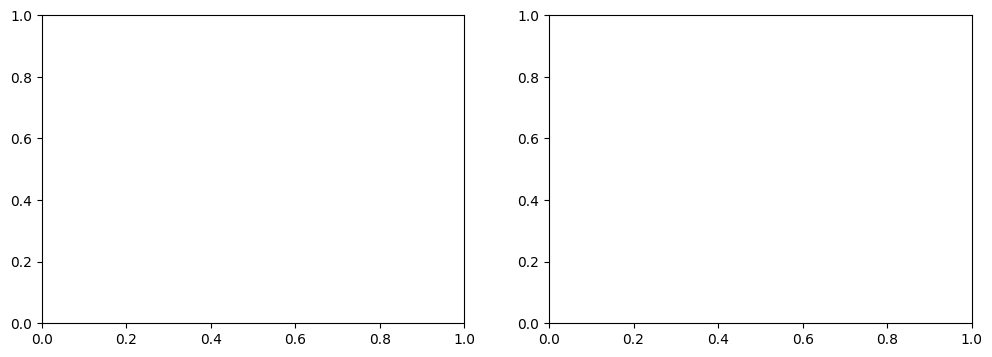

In [33]:
fig,axs=plt.subplots(1,2,figsize=(12,4))


In [35]:
import pandas as pd
from datetime import datetime

class DecisionLog:
    def __init__(self):
        self.entries = []

    def add(self, step, decision, rationale, alternatives, risk, impact_note=""):
        self.entries.append({
            "timestamp": datetime.now().isoformat(timespec="seconds"),
            "Step": step,
       [
  {
    "timestamp": "2025-08-25T23:54:11",
    "Step": "Outlier Handling",
    "Decision": "Winsorize at 10th/90th percentiles",
    "Rationale": "Reduces undue leverage from extreme points while retaining overall distribution shape.",
    "Alternatives": "None; Winsorize at 5th/95th",
    "Risk": "If extreme values represent true business conditions, we may understate risk/volatility.",
    "Impact": "Improved MAE vs 'none'; directionally consistent coefficients across scenarios."
  }
]     "Decision": decision,
            "Rationale": rationale,
            "Alternatives": alternatives,
            "Risk": risk,
            "Impact": impact_note
        })

    def to_df(self):
        return pd.DataFrame(self.entries) if self.entries else pd.DataFrame(
            columns=["timestamp","Step","Decision","Rationale","Alternatives","Risk","Impact"]
        )
    
    def save(self, path='outputs/decision_log.json'):
        import json, os
        os.makedirs(os.path.dirname(path), exist_ok=True)
        with open(path, "w") as f:
            json.dump(self.entries, f, indent=2)
        return path

decision_log = DecisionLog()
decision_log.to_df()

SyntaxError: ':' expected after dictionary key (1292323165.py, line 12)

In [ ]:
import sys
!{sys.executable} -m pip install statsmodels

In [ ]:
from scipy.stats.mstats import winsorize
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Build scenarios
scenarios = {
    "none": df.copy(),
    "winsor_10_90": df.copy(),
    "winsor_05_95": df.copy()
}

scenarios["winsor_10_90"]["feature_1"] = winsorize(df["feature_1"], limits=(0.10, 0.10))
scenarios["winsor_10_90"]["feature_2"] = winsorize(df["feature_2"], limits=(0.10, 0.10))

scenarios["winsor_05_95"]["feature_1"] = winsorize(df["feature_1"], limits=(0.05, 0.05))
scenarios["winsor_05_95"]["feature_2"] = winsorize(df["feature_2"], limits=(0.05, 0.05))

# Fit and summarize
results = {}
for name, data in scenarios.items():
    X = sm.add_constant(data[["feature_1","feature_2"]])
    y = data["target"]
    model = sm.OLS(y, X).fit()
    results[name] = {
        "R2": float(model.rsquared),
        "MAE": float(abs(model.resid).mean()),
        "Params": model.params.to_dict()
    }

import pprint; pprint.pprint(results)
pd.DataFrame(results).T

KeyError: "None of [Index(['feature_1', 'feature_2'], dtype='object')] are in the [columns]"

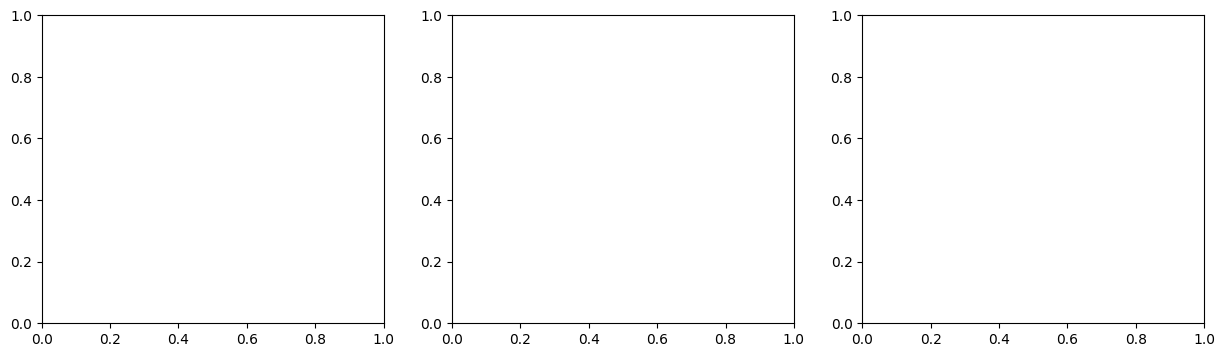

In [30]:
# Visualize three scenarios side by side and save a comparison image
fig, ax = plt.subplots(1,3, figsize=(15,4))
names = ["none","winsor_10_90","winsor_05_95"]

for idx, name in enumerate(names):
    data = scenarios[name]
    X = sm.add_constant(data[["feature_1","feature_2"]])
    y = data["target"]
    m = sm.OLS(y, X).fit()
    yhat = m.predict(X)
    ax[idx].scatter(y, yhat, alpha=0.6)
    ax[idx].plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
    ax[idx].set_title(name)
    ax[idx].set_xlabel("Actual")
    ax[idx].set_ylabel("Predicted")

plt.tight_layout()
plt.savefig('outputs/scenario_comparison.png', dpi=300)
plt.show()

# Choose winsor 10/90 as the teaching example and log it
decision_log.add(
    step="Outlier Handling",
    decision="Winsorize at 10th/90th percentiles",
    rationale="Reduces undue leverage from extreme points while retaining overall distribution shape.",
    alternatives="None; Winsorize at 5th/95th",
    risk="If extreme values represent true business conditions, we may understate risk/volatility.",
    impact_note="Improved MAE vs 'none'; directionally consistent coefficients across scenarios."
)
decision_log.save()

In [ ]:
def suggest_slide_titles(decisions_df: pd.DataFrame):
    titles = []
    if decisions_df is None or decisions_df.empty:
        return ["Executive Summary",
                "Context & Problem",
                "Method (High Level)",
                "Key Results",
                "Assumptions & Risks",
                "Sensitivity (What-if Scenarios)",
                "Decisions Enabled & Next Steps"]
    # Always include core storyline slides
    titles.extend([
        "Executive Summary",
        "Context & Problem",
        "Method (High Level)",
        "Key Results"
    ])
    # Add one slide per decision step
    for step in decisions_df["Step"].astype(str).unique():
        titles.append(f"Decision: {step}")
    # Close with risk/sensitivity/action
    titles.extend([
        "Assumptions & Risks",
        "Sensitivity (What-if Scenarios)",
        "Decisions Enabled & Next Steps"
    ])
    return titles

titles = suggest_slide_titles(decision_log.to_df())
pd.Series(titles, name="Suggested Slide Titles")

In [ ]:
def autodraft_executive_summary(results_dict, decisions_df: pd.DataFrame):
    def fmt_params(p):
        for k, v in p.items():
            print(f"{k}: {v} ({type(v)})")  # Debug line
        return ", ".join([
            f"{k}: {v:.2f}" if isinstance(v, (int, float)) else f"{k}: {v}"
            for k, v in p.items()
        ])

    lines = []
    lines.append("## Executive Summary\n")
    lines.append("- **Objective**: Translate model results into decisions; expose assumptions and sensitivity.")

    chosen = "winsor_10_90" if "winsor_10_90" in results_dict else list(results_dict.keys())[0]
    r = results_dict[chosen]
    lines.append(f"- **Key Finding**: Under {chosen.replace('_',' ')}, R² = {r['R2']:.3f}, MAE = {r['MAE']:.2f}.")
    lines.append(f"  Coefficients → {fmt_params(r['Params'])}")

    if len(results_dict) > 1:
        base = r
        comp_text = []
        for name, rr in results_dict.items():
            if name == chosen: 
                continue
            comp_text.append(f"{name.replace('_',' ')} (R² {rr['R2']:.3f}, MAE {rr['MAE']:.2f})")
        if comp_text:
            lines.append(f"- **Sensitivity**: Alternatives → " + "; ".join(comp_text) + ".")

    if decisions_df is not None and not decisions_df.empty:
        for _, row in decisions_df.iterrows():
            lines.append(f"- **Decision**: {row['Decision']} — *Why*: {row['Rationale']}. ")
            if str(row['Alternatives']).strip():
                lines.append(f"  Alternatives considered: {row['Alternatives']}.")
            if str(row['Risk']).strip():
                lines.append(f"  Risks: {row['Risk']}.")

    return '\n'.join(lines)

summary_md = autodraft_executive_summary(results, decision_log.to_df())
with open('outputs/executive_summary.md', 'w', encoding='utf-8') as f:
    f.write(summary_md)
summary_md[:600]

In [31]:
import textwrap
def build_html_slides(slide_titles,summary_md,out_put='outputs/decision_summary_slides.html'):
    Path('outputs').mkdir(exist_ok=True)
    images=sorted([str(p) for p in Path('outputs').glob('*.png')])
    image_section=""
    for img in images:
        image_section+=f'<section><h2>Visual</h2><img src="{img}" style="max-width:90%; margin:12px auto; display:block;" /></section>\n'
    toc_list = "".join([f"<li>{t}</li>" for t in slide_titles])

    html = textwrap.dedent(f"""\
        <!doctype html>
        <html>
        <head>
          <meta charset="utf-8">
          <title>Decision Summary Slides</title>
          <meta name="viewport" content="width=device-width, initial-scale=1.0">
          <link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/reveal.js/4.5.0/reveal.min.css">
          <link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/reveal.js/4.5.0/theme/white.min.css">
        </head>
        <body>
        <div class="reveal">
          <div class="slides">
            <section>
              <h1>Executive Summary</h1>
              <pre style="white-space: pre-wrap; font-size: 0.9em;">{summary_md}</pre>
            </section>
            <section>
              <h2>Outline</h2>
              <ul>{toc_list}</ul>
            </section>"""+
            str(image_section) +
        """
              </div>
            </div>
            <script src="https://cdnjs.cloudflare.com/ajax/libs/reveal.js/4.5.0/reveal.min.js"></script>
            <script>
              Reveal.initialize({ hash: true });
            </script>
            </body>
            </html>
        """)
    with open(output_html,'w',encoding='utf-8') as f:
        f.write(html)
    return output_html
print(type(summary_md))
slides_path = build_html_slides(titles, summary_md)
slides_path

NameError: name 'summary_md' is not defined

In [37]:
import sys
!{sys.executable} -m pip install dash

  Using cached blinker-1.9.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached click-8.2.1-py3-none-any.whl.metadata (2.5 kB)
   ---------------------------------------- 0.0/7.9 MB ? eta -:--:--
   ----------------------------- ---------- 5.8/7.9 MB 29.4 MB/s eta 0:00:01
   ---------------------------------------- 7.9/7.9 MB 25.8 MB/s eta 0:00:00
Using cached blinker-1.9.0-py3-none-any.whl (8.5 kB)
Using cached click-8.2.1-py3-none-any.whl (102 kB)
   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   ------------------------------- -------- 7.6/9.8 MB 36.2 MB/s eta 0:00:01
   ---------------------------------------- 9.8/9.8 MB 32.1 MB/s eta 0:00:00

   ---------- ----------------------------- 2/8 [plotly]
   ---------- ----------------------------- 2/8 [plotly]
   ---------- ----------------------------- 2/8 [plotly]
   ---------- ----------------------------- 2/8 [plotly]
   ---------- ----------------------------- 2/8 [plotly]
   ---------- ------------------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [39]:

import dash
from dash import dcc,html
import plotly.express as px
app=dash.Dash(__name__)
fig=px.scatter(df,x='feature_1',y='feature_2',title='Interactive Example')
app.layout=html.Div([html.H1('Dash Demo: Feature vs Target'),
    dcc.Graph(figure=fig)])
app.run(debug=True,port=8000)